# Customer Revenue Prediction

## Baseline Light GBM Model
*Machine Learning Nanodegree Program | Capstone Project*

---

In this notebook I will be creating a baseline model that can be used to evaluate the performance of the Pytorch model that I will be creating as part of the project.

### Overview:
- Reading the data
- Initializing the Light GBM model
- Training the model with the train dataset
- Validating the model using the val dataset
- Predict the revenue for customer in test dataset
- Visualizing the results
- Saving the base line results to a csv 

First, import the relevant libraries into notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMModel
from os import path
from sklearn.metrics import mean_squared_error

Set the various paths for the training, validation, test files and storing the baseline results

In [2]:
files_dir = '../data/files'

if not path.exists(files_dir):
    raise Exception('{} directory not found.'.format(
        files_dir
    ))

train_file = '{}/{}'.format(files_dir, 'train.zip')
print('\nTrain file: {}'.format(train_file))

val_file = '{}/{}'.format(files_dir, 'val.zip')
print('\nVal file: {}'.format(val_file))

test_file = '{}/{}'.format(files_dir, 'test.zip')
print('\nTest file: {}'.format(test_file))

baseline_file = '{}/{}'.format(files_dir, 'baseline.zip')
print('\nBaseline file: {}'.format(baseline_file))

imp_features_file = '{}/{}'.format(files_dir, 'lgbm_importances-01.png')
print('\nImportant Features file: {}'.format(imp_features_file))


Train file: ../data/files/train.zip

Val file: ../data/files/val.zip

Test file: ../data/files/test.zip

Baseline file: ../data/files/baseline.zip

Important Features file: ../data/files/lgbm_importances-01.png


Method to load the dataset from the files

In [3]:
def load_data(zip_path):
    df = pd.read_csv(
        zip_path,
        dtype={'fullVisitorId': 'str'},
        compression='zip'
    )
    
    [rows, columns] = df.shape

    print('\nLoaded {} rows with {} columns from {}.\n'.format(
        rows, columns, zip_path
    ))
    
    return df

Load the train, validation and test datasets.

In [4]:
%%time

train_df = load_data(train_file)
val_df = load_data(val_file)
test_df = load_data(test_file)


Loaded 765707 rows with 26 columns from ../data/files/train.zip.


Loaded 137946 rows with 26 columns from ../data/files/val.zip.


Loaded 804684 rows with 25 columns from ../data/files/test.zip.

CPU times: user 8.28 s, sys: 506 ms, total: 8.78 s
Wall time: 9.05 s


For the LightBGM model, the labels should be separated from the features. I only need the _**fullVisitorId**_ to identify the customer and not for the training of the model. So I will drop the _**fullVisitorId**_ and _**totals.transactionRevenue**_ from the training and validation datasets and store them separately so that I can evaluate the results at later stage. From the test dataset we only need to drop _**fullVisitorId**_

In [5]:
train_id = train_df["fullVisitorId"].values
val_id = val_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

train_y = np.log1p(train_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

train_X = train_df.drop(['totals.transactionRevenue', 'fullVisitorId'], axis=1)
val_X = val_df.drop(['totals.transactionRevenue', 'fullVisitorId'], axis=1)
test_X = test_df.drop(['fullVisitorId'], axis=1)

In [6]:
print('\nShape of the train dataset: {}'.format(train_X.shape))
print('\nShape of the val dataset: {}'.format(val_X.shape))
print('\nShape of the test dataset: {}\n'.format(test_X.shape))


Shape of the train dataset: (765707, 24)

Shape of the val dataset: (137946, 24)

Shape of the test dataset: (804684, 24)



,channelGrouping,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,...,trafficSource.keyword,trafficSource.medium,trafficSource.source,trafficSource.referralPath,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,visitNumber,visitStartTime
0,0.571429,0.284483,0.0,0.0,0.869565,0.395178,0.4,0.925110,0.595041,0.892208,...,0.113337,0.8,0.416834,1.0,1.0,0.0,1.0,0.0,0.000000,0.088405
1,0.571429,0.353448,0.0,0.0,0.260870,0.579665,1.0,0.048458,0.595041,0.240549,...,0.113337,0.8,0.416834,1.0,1.0,0.0,1.0,0.0,0.000000,0.089979
2,0.571429,0.284483,0.0,0.0,0.869565,0.496855,0.6,0.814978,0.595041,0.007671,...,0.113337,0.8,0.416834,1.0,1.0,0.0,1.0,0.0,0.000000,0.089512
3,0.571429,0.672414,0.0,0.0,0.217391,0.579665,0.4,0.409692,0.595041,0.007671,...,0.298089,0.8,0.416834,1.0,1.0,0.0,1.0,0.0,0.000000,0.090012
4,0.571429,0.284483,0.5,1.0,0.000000,0.579665,0.6,0.955947,0.595041,0.007671,...,0.113337,0.8,0.416834,1.0,1.0,0.0,0.0,0.0,0.002538,0.088159


I will be using the [LGBMModel](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMModel.html#lightgbm.LGBMModel). This funtion creates the model trains the model using the train set and predicts the transaction revenue for val and test dataset.

In [7]:
def lgbm_model(train_X, train_y, val_X, val_y, test_X):
    model = LGBMModel(
        objective='regression',
        metric='rmse',
        n_estimators=1000,
        learning_rate= 0.1,
        min_child_samples=100,
        bagging_fraction=0.7,
        feature_fraction=0.5,
        bagging_freq=5,
        bagging_seed=2020
    )
    
    model = model.fit(
        train_X, 
        train_y, 
        eval_set=(val_X, val_y),
        early_stopping_rounds=100,
        verbose=100
    )
        
    pred_test_y = model.predict(
        test_X, 
        num_iteration=model.best_iteration_
    )
    pred_val_y = model.predict(
        val_X, 
        num_iteration=model.best_iteration_
    )
    
    return pred_test_y, pred_val_y, model

In [8]:
pred_test, pred_val, model = lgbm_model(train_X, train_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.70385
[200]	valid_0's rmse: 1.69903
[300]	valid_0's rmse: 1.69869
Early stopping, best iteration is:
[283]	valid_0's rmse: 1.69773


In order to evaluate the model, I will be calculating the Root Mean Squared Error between the actual _**total.transactionRevenue**_ and the _**predictedRevenue**_ for the validation sets

In [9]:
pred_val[pred_val < 0] = 0

pred_val_df = pd.DataFrame({ 'fullVisitorId': val_id })
pred_val_df['transactionRevenue'] = val_df["totals.transactionRevenue"].values
pred_val_df['predictedRevenue'] = np.expm1(pred_val)

pred_val_df = pred_val_df.groupby('fullVisitorId')['transactionRevenue', 'predictedRevenue'].sum().reset_index()

rsme_val = np.sqrt(
    mean_squared_error(
        np.log1p(pred_val_df["transactionRevenue"].values), 
        np.log1p(pred_val_df["predictedRevenue"].values))
)

print('\nRSME for validation data set: {:.3f}\n'.format(rsme_val))


RSME for validation data set: 1.716



We will use this RSME as the baseline and compare this model with the Pytorch model that will be created to evaluate which model is better

<br />
Now lets create a base line output file for the predictions for the test dataset. 

In [10]:
baseline_df = pd.DataFrame({ 'fullVisitorId': test_id })

pred_test[pred_test < 0] = 0

baseline_df['predictedRevenue'] = np.expm1(pred_test)

baseline_df = baseline_df.groupby('fullVisitorId')['predictedRevenue'].sum().reset_index()

baseline_df.columns = ['fullVisitorId', 'predictedRevenue']

baseline_df["predictedRevenue"] = np.log1p(baseline_df["predictedRevenue"])

baseline_df.to_csv(baseline_file, index=False, compression='zip')

In [11]:
baseline_df.head()

,fullVisitorId,predictedRevenue
0,0000000259678714014,0.214314
1,0000049363351866189,0.000765
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.000000


Visualization to see the feature importances for the model 


-0.4 0 1384.0
0.4 1388.6

0.6 0 1277.0
0.4 1282.6

1.6 0 1113.0
0.4 1119.6

2.6 0 662.0
0.4 669.6

3.6 0 542.0
0.4 550.6

4.6 0 497.0
0.4 506.6

5.6 0 409.0
0.4 419.6

6.6 0 335.0
0.4 346.6

7.6 0 326.0
0.4 338.6

8.6 0 280.0
0.4 293.6

9.6 0 219.0
0.4 233.6

10.6 0 201.0
0.4 216.6

11.6 0 191.0
0.4 207.6

12.6 0 174.0
0.4 191.6

13.6 0 155.0
0.4 173.6

14.6 0 130.0
0.4 149.6

15.6 0 107.0
0.4 127.6

16.6 0 100.0
0.4 121.6

17.6 0 84.0
0.4 106.6

18.6 0 81.0
0.4 104.6

19.6 0 70.0
0.4 94.6

20.6 0 63.0
0.4 88.6

21.6 0 62.0
0.4 88.6

22.6 0 28.0
0.4 55.6


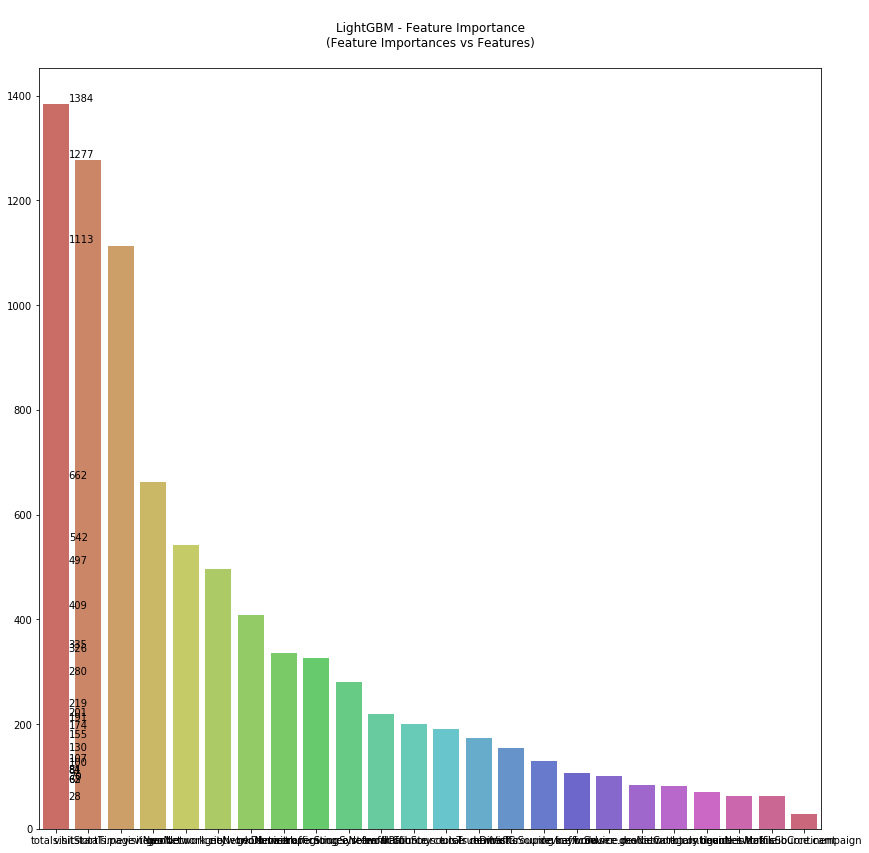

In [89]:
feature_imp = pd.DataFrame({
    'Values':model.feature_importances_,
    'Features':train_X.columns
})

feature_imp = feature_imp.sort_values(by="Values", ascending=False)

plt.figure(figsize=(14, 14))

sns_bar = sns.barplot(
    x="Values", 
    y="Features", 
    data=feature_imp,
    orient='V',
    palette="hls",
)

for patch in sns_bar.patches:
    x = patch.get_x() + patch.get_width() + 5
    y = patch.get_y() + (patch.get_height() / 2)
    sns_bar.annotate(int(patch.get_width()), (x, y))

plt.title(
    "\nLightGBM - Feature Importance\n(Feature Importances vs Features)\n", 
    fontsize=12
)
plt.xlabel('') 
plt.ylabel('') 

plt.savefig(
    fname=imp_features_file,
    bbox_inches = "tight"
)

plt.show()


From the above plot, we see that **_totals.hits_**, **_visitStartTime_** and **_totals.pageviews_** are the most important features